## 1. Random Forest

{0, 1}


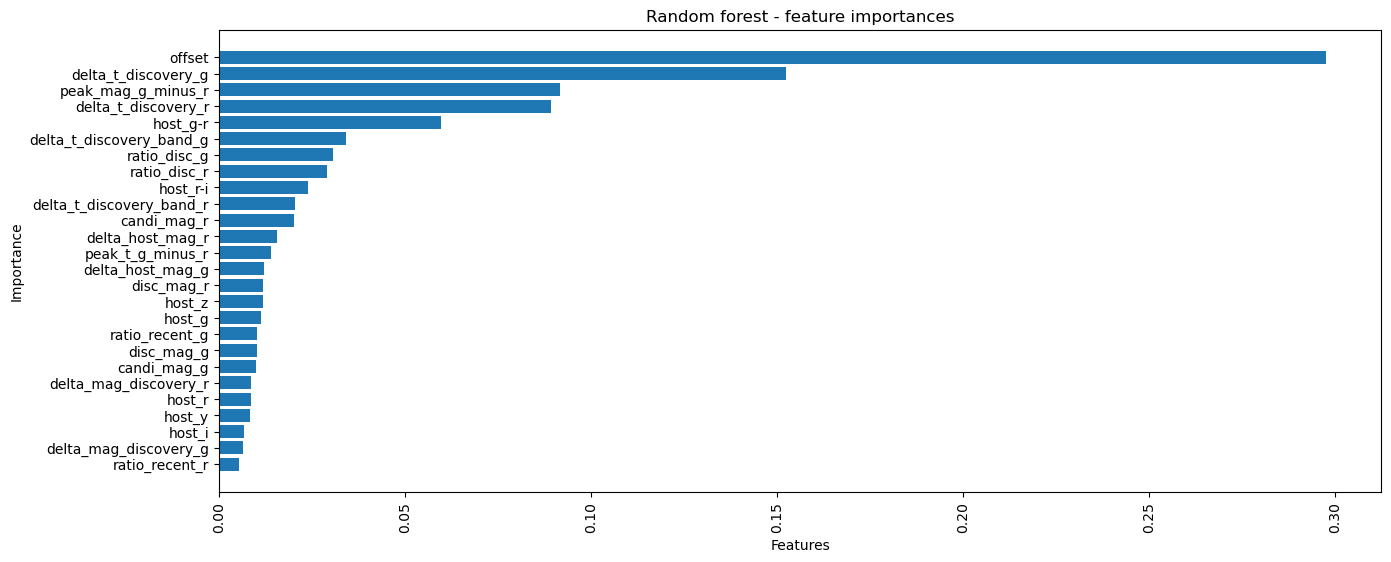

In [312]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from preprocessing import open_with_h5py, preprocessing
import json

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance


filepath = '/Users/xinyuesheng/Documents/astro_projects/scripts/classifier_v1/model_with_data/mixed_band/mixed_nor1_add_disc_t_ext_20240628/data.hdf5'
# label_path = '../model_labels/SLSN_label_dict.json'

label_path = '../model_labels/label_dict_equal_test.json'
label_dict = open(label_path,'r')
label_dict = json.loads(label_dict.read())

# Load the Iris dataset - replace with light curve features
imageset, labels, metaset, idx_set = open_with_h5py(filepath)

for k in label_dict['classify'].keys():
        if label_dict['classify'][k] not in label_dict['label'].values():
            ab_idx = np.where(labels == label_dict["classify"][k])
            imageset, metaset, labels = np.delete(imageset, ab_idx, 0), np.delete(metaset, ab_idx, 0), np.delete(labels, ab_idx, 0)
            idx_set = np.delete(idx_set, ab_idx, 0)

# labels[labels!=1] = 0 # SLSN binary classifier

labels[labels!=2] = 0 # TDE binary classifier
labels[labels == 2] = 1

X = np.nan_to_num(metaset)
y = labels

print(set(y))
class_weight = {}
for i in np.arange(len(set(labels.flatten()))):
    class_weight[i] = labels.shape[0]/len(np.where(labels.flatten()==i)[0])


# Initialize and train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=4, class_weight = class_weight)
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
# = obj_meta_r + obj_meta_g + [peak_mag_g_minus_r, peak_t_g_minus_r] + host_meta + sher_meta
feature_names = ['candi_mag_r', 'disc_mag_r', 'delta_mag_discovery_r', 'delta_t_discovery_band_r', 'delta_t_discovery_r', 'ratio_recent_r', 'ratio_disc_r', 'delta_host_mag_r',
                 'candi_mag_g', 'disc_mag_g', 'delta_mag_discovery_g', 'delta_t_discovery_band_g', 'delta_t_discovery_g', 'ratio_recent_g', 'ratio_disc_g', 'delta_host_mag_g',
                  'peak_mag_g_minus_r', 'peak_t_g_minus_r', 
                  'host_g','host_r','host_i','host_z','host_y', 'host_g-r', 'host_r-i', 
                  'offset']
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Visualize feature importances
plt.figure(figsize=(15, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Random forest - feature importances')
plt.xticks(rotation=90)
plt.show()


## 2. Extreme Gradient Boosting

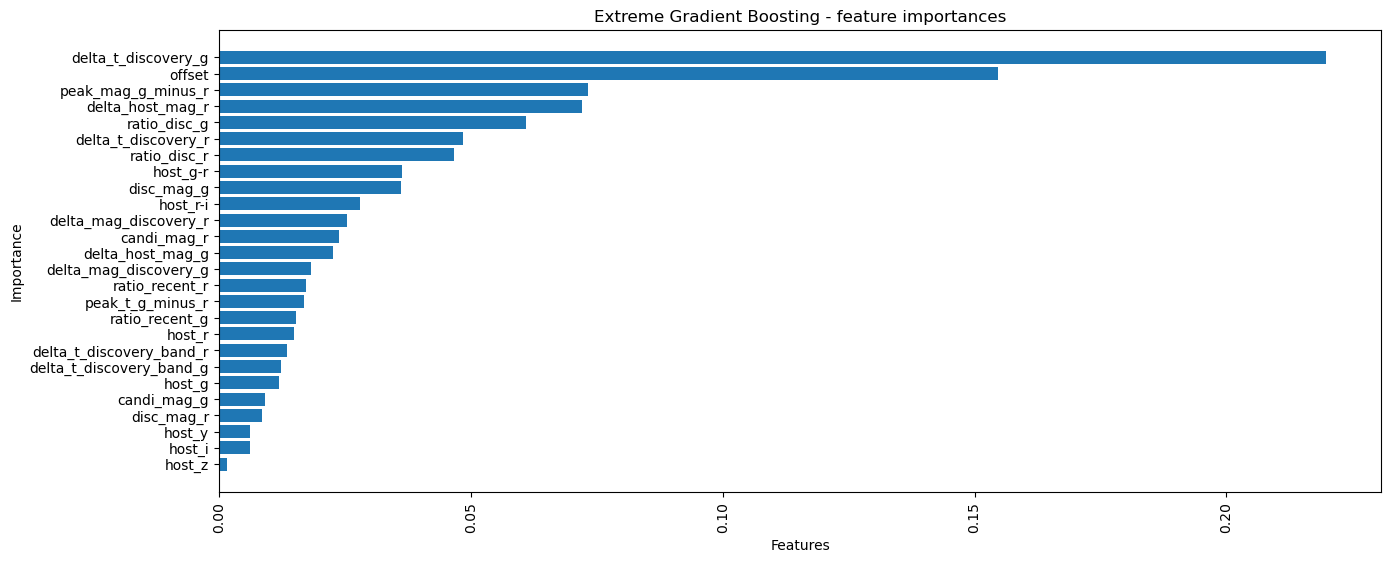

In [313]:
import xgboost as xgb
from xgboost import plot_importance

xgb_model = xgb.XGBClassifier()
xgb_model.fit(X, labels)
importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)
plt.figure(figsize=(15, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Extreme Gradient Boosting - feature importances')
plt.xticks(rotation=90)
plt.show()


# plt.figure(figsize=(15, 6))
# ax1 = plot_importance(xgb_model)
# ax1.set_yticklabels(feature_names)
# ax1.set_title('Extreme Gradient Boosting - feature importance')
# plt.show()

## Correlation map

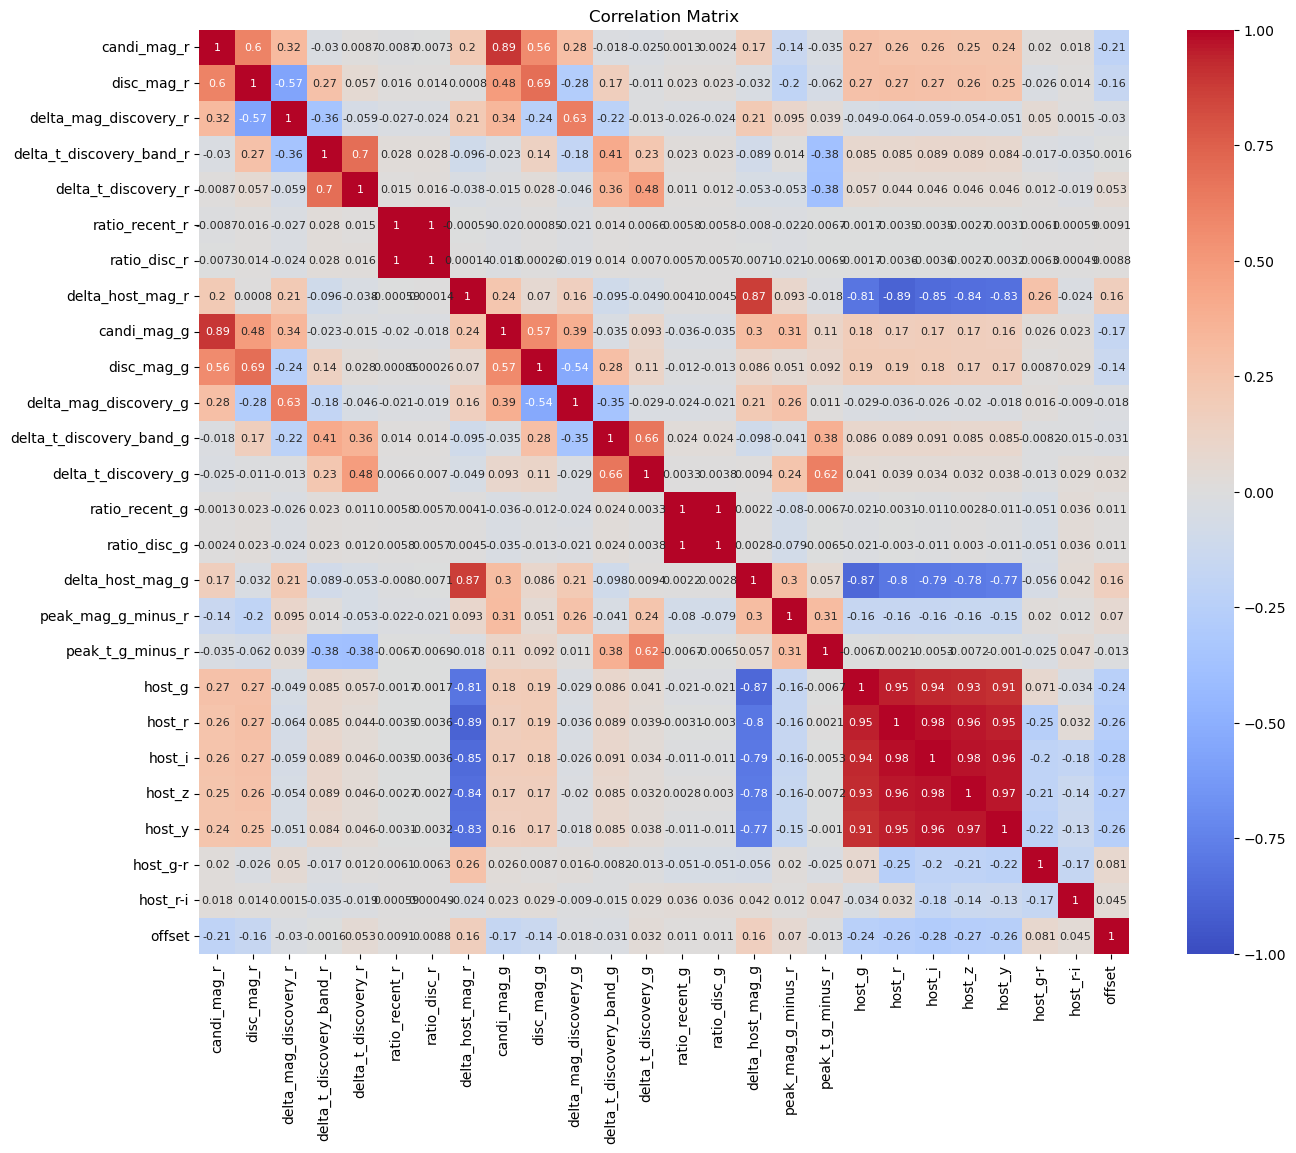

In [314]:
import seaborn as sns
df = pd.DataFrame(metaset, columns=feature_names)
correlation_matrix = df.corr()

# Plot the heatmap2
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1,annot_kws={"size": 8})
plt.title('Correlation Matrix')
plt.show()

try to remove correlated features,than rank them, compare the differences.

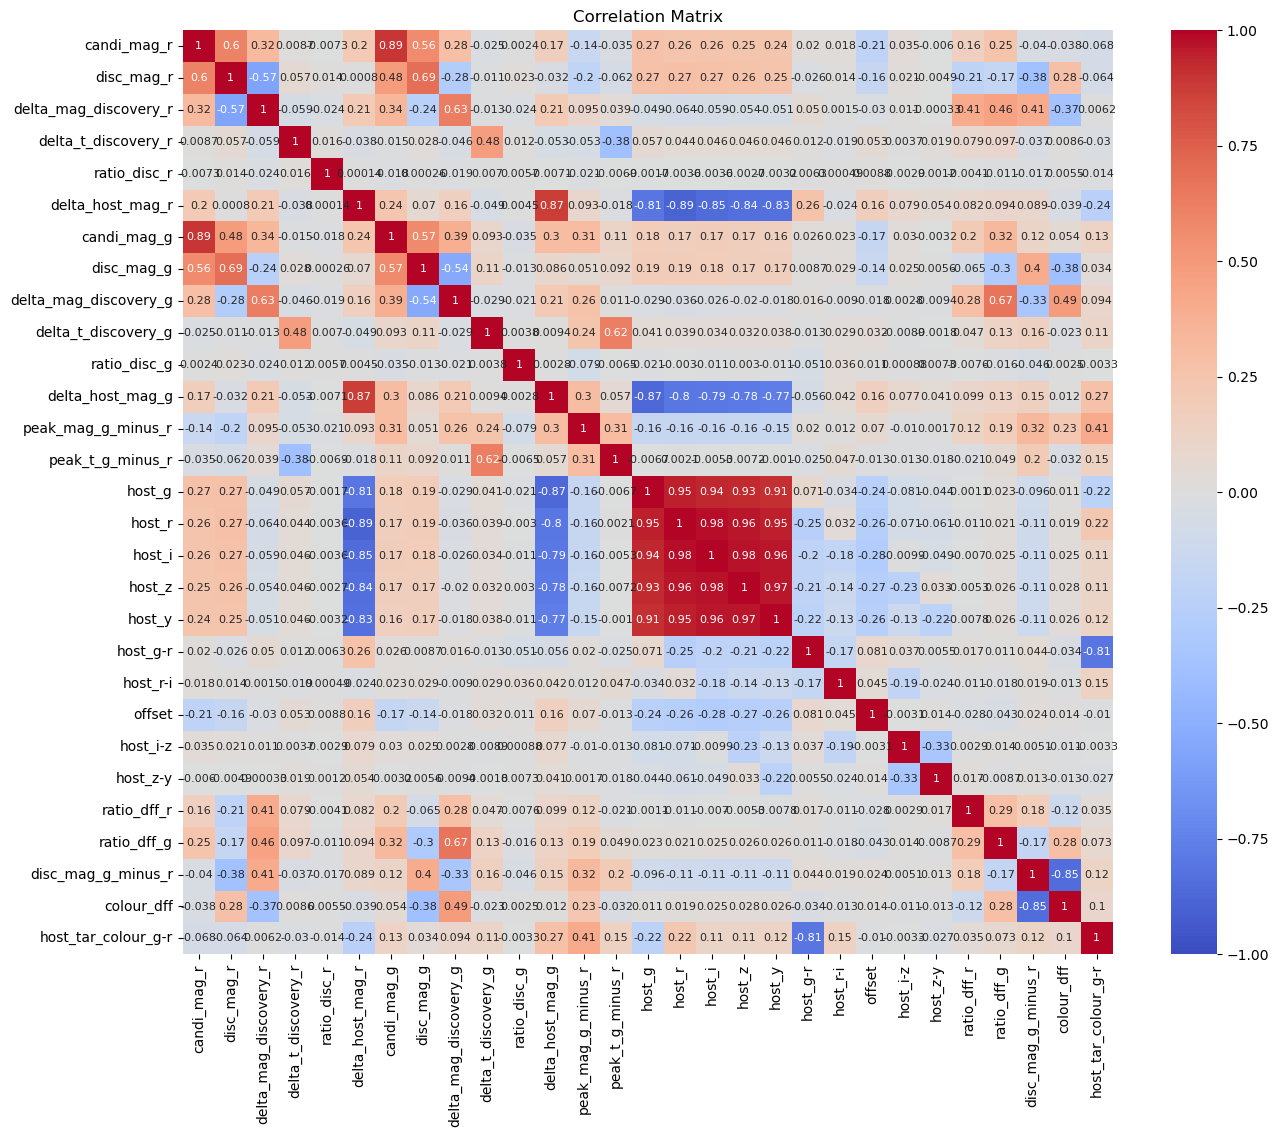

In [315]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.DataFrame(metaset, columns=feature_names)

# df['host_i-z'] = df['host_i'] - df['host_z']
# df['host_z-y'] = df['host_z'] - df['host_y']
# df['ratio_dff_r']  = df['ratio_disc_r'] - df['ratio_recent_r']
# df['ratio_dff_g']  = df['ratio_disc_g'] - df['ratio_recent_g']
# # df['candi_g-r'] = df['candi_mag_g'] - df['candi_mag_r'] # this is wrong, as candi_g-r is peak_mag_g_minus_r, the difference is the latter corrected to 0 when one band data is not available.
# df['disc_mag_g_minus_r'] = df.apply(lambda row: 0 if row['disc_mag_g'] == 0 or row['disc_mag_r'] == 0 else row['disc_mag_g'] - row['disc_mag_r'], axis=1)
# df['colour_dff'] = df.apply(lambda row: 0 if row['peak_mag_g_minus_r'] == 0 or row['disc_mag_g_minus_r'] == 0 else row['peak_mag_g_minus_r'] - row['disc_mag_g_minus_r'], axis=1)

# df['host_tar_colour_g-r'] = df['delta_host_mag_g'] - df['delta_host_mag_r']
# df_cm = df.drop(['host_i', 'host_z', 'host_y', 'host_g', 'ratio_recent_r', 'ratio_recent_g', 'candi_mag_r', 'delta_host_mag_g', 'delta_t_discovery_band_r', 'delta_t_discovery_band_g'], axis = 1)

# feature_names = ['candi_mag_r', 'disc_mag_r', 'delta_mag_discovery_r', 'delta_t_discovery_band_r', 'delta_t_discovery_r', 'ratio_recent_r', 'ratio_disc_r', 'delta_host_mag_r',
#                  'candi_mag_g', 'disc_mag_g', 'delta_mag_discovery_g', 'delta_t_discovery_band_g', 'delta_t_discovery_g', 'ratio_recent_g', 'ratio_disc_g', 'delta_host_mag_g',
#                   'peak_mag_g_minus_r', 'peak_t_g_minus_r', 
#                   'host_g','host_r','host_i','host_z','host_y', 'host_g-r', 'host_r-i', 
#                   'offset']
# df = pd.DataFrame(metadata, columns=feature_names)
df['host_i-z'] = df['host_i'] - df['host_z']
df['host_z-y'] = df['host_z'] - df['host_y']
df['ratio_dff_r']  = df['ratio_disc_r'] - df['ratio_recent_r']
df['ratio_dff_g']  = df['ratio_disc_g'] - df['ratio_recent_g']
df['disc_mag_g_minus_r'] = df.apply(lambda row: 0 if row['disc_mag_g'] == 0 or row['disc_mag_r'] == 0 else row['disc_mag_g'] - row['disc_mag_r'], axis=1)
df['colour_dff'] = df.apply(lambda row: 0 if row['peak_mag_g_minus_r'] == 0 or row['disc_mag_g_minus_r'] == 0 else row['peak_mag_g_minus_r'] - row['disc_mag_g_minus_r'], axis=1)
df['host_tar_colour_g-r'] = df['delta_host_mag_g'] - df['delta_host_mag_r']
df_cm = df.drop(['ratio_recent_r', 'ratio_recent_g', 'delta_t_discovery_band_r', 'delta_t_discovery_band_g'], axis = 1)

# Calculate the correlation matrix
correlation_matrix = df_cm.corr()

# Plot the heatmap2
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1,annot_kws={"size": 8})
plt.title('Correlation Matrix')
plt.show()


## Another method to check the correlation

In [59]:
# import pandas as pd
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.tools.tools import add_constant

# def calculate_vif(df):
#     # Add a constant (intercept) to the model
#     df_with_const = add_constant(df)
    
#     # Calculate VIF for each feature
#     vif = pd.DataFrame()
#     vif["Feature"] = df.columns
#     vif["VIF"] = [variance_inflation_factor(df_with_const.values, i+1) for i in range(df.shape[1])]
#     return vif.sort_values('VIF', ascending=False)

# # df = pd.DataFrame(metaset, columns=feature_names)
# df_rn = df_cm.fillna(0)  #.drop(['disc_mag_g', 'disc_mag_r', 'candi_mag_g', 'delta_host_mag_r'], axis = 1)

# # df_pick = df[['disc_mag_g', 'disc_mag_r', 'ratio_recent_g', 'ratio_recent_r', 'candi_mag_g', 'delta_host_mag_r']].fillna(0)
# # calculate_vif(df_pick)

# calculate_vif(df_rn)




## Test on algorithms the change of the feature ranking

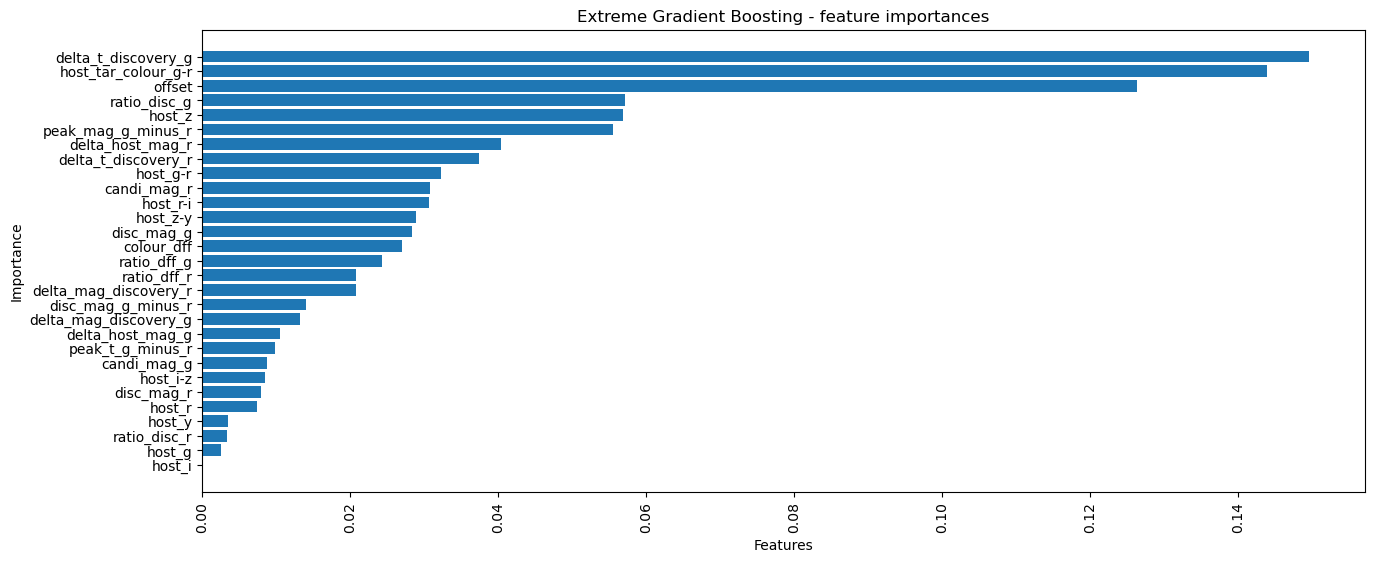

In [316]:
import xgboost as xgb
from xgboost import plot_importance

xgb_model = xgb.XGBClassifier()
xgb_model.fit(df_cm, labels)
feature_names = df_cm.columns

importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)
plt.figure(figsize=(15, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Extreme Gradient Boosting - feature importances')
plt.xticks(rotation=90)
plt.show()


# feature_names = df_cm.columns
# plt.figure(figsize=(15, 6))
# ax2 = plot_importance(model)
# ax2.set_yticklabels(feature_names)
# ax2.set_title('Extreme Gradient Boosting - feature importance (after vetting)')
# plt.show()

In [317]:
import json
rk_dict = {}
n = 0
for i in feature_names:
    rk_dict[i] = xgb_model.feature_importances_[n].astype('float64')
    n += 1
print(rk_dict)
with open('/Users/xinyuesheng/Documents/astro_projects/scripts/classifier_v1/model_with_data/mixed_band/mixed_nor1_add_disc_t_ext_20240628/tde_xgb_binary_ranking.json', 'w') as f:
    json.dump(rk_dict, f, indent = 4)

{'candi_mag_r': 0.03070484846830368, 'disc_mag_r': 0.007992647588253021, 'delta_mag_discovery_r': 0.020774608477950096, 'delta_t_discovery_r': 0.03733861818909645, 'ratio_disc_r': 0.003377256914973259, 'delta_host_mag_r': 0.0403483547270298, 'candi_mag_g': 0.008808356709778309, 'disc_mag_g': 0.02831489033997059, 'delta_mag_discovery_g': 0.013243250548839569, 'delta_t_discovery_g': 0.14958606660366058, 'ratio_disc_g': 0.057162415236234665, 'delta_host_mag_g': 0.010522356256842613, 'peak_mag_g_minus_r': 0.05548170953989029, 'peak_t_g_minus_r': 0.009822490625083447, 'host_g': 0.0025161984376609325, 'host_r': 0.007344406563788652, 'host_i': 0.0, 'host_z': 0.056837402284145355, 'host_y': 0.003529289271682501, 'host_g-r': 0.03222339227795601, 'host_r-i': 0.030584314838051796, 'offset': 0.12626416981220245, 'host_i-z': 0.008465117774903774, 'host_z-y': 0.028824444860219955, 'ratio_dff_r': 0.020811691880226135, 'ratio_dff_g': 0.024331597611308098, 'disc_mag_g_minus_r': 0.013993059284985065, 'c

In [251]:
# Get feature importances
xgb_feature_importances = xgb_model.feature_importances_
print("Feature Importances: ", xgb_feature_importances)
print(sum(xgb_feature_importances))


Feature Importances:  [0.02386044 0.01895866 0.03952861 0.         0.04933371 0.01295567
 0.022588   0.0038203  0.16824423 0.08366159 0.07344826 0.01066547
 0.01296681 0.04948407 0.04276627 0.15817715 0.00958806 0.03434166
 0.02384402 0.00892832 0.0144136  0.01789247 0.12053261]
0.9999999720603228


In [168]:
n = 0
for i in df_cm.columns.values.tolist():
    print(i, xgb_feature_importances[n])
    n += 1

disc_mag_r 0.04401327
delta_mag_discovery_r 0.01290249
delta_t_discovery_r 0.11646154
ratio_disc_r 0.033598714
delta_host_mag_r 0.042039607
candi_mag_g 0.02076311
disc_mag_g 0.02548495
delta_mag_discovery_g 0.004217595
delta_t_discovery_g 0.12311972
ratio_disc_g 0.041376773
peak_mag_g_minus_r 0.04134923
peak_t_g_minus_r 0.06817981
host_r 0.14212954
host_g-r 0.028865084
host_r-i 0.01955126
offset 0.021163775
host_i-z 0.017600974
host_z-y 0.023842515
ratio_dff_r 0.043548763
ratio_dff_g 0.039985385
disc_mag_g_minus_r 0.05436972
colour_dff 0.0205798
host_tar_colour_g-r 0.014856428


In [98]:
sum(xgb_feature_importances)

1.0000000383879524

{0, 1}


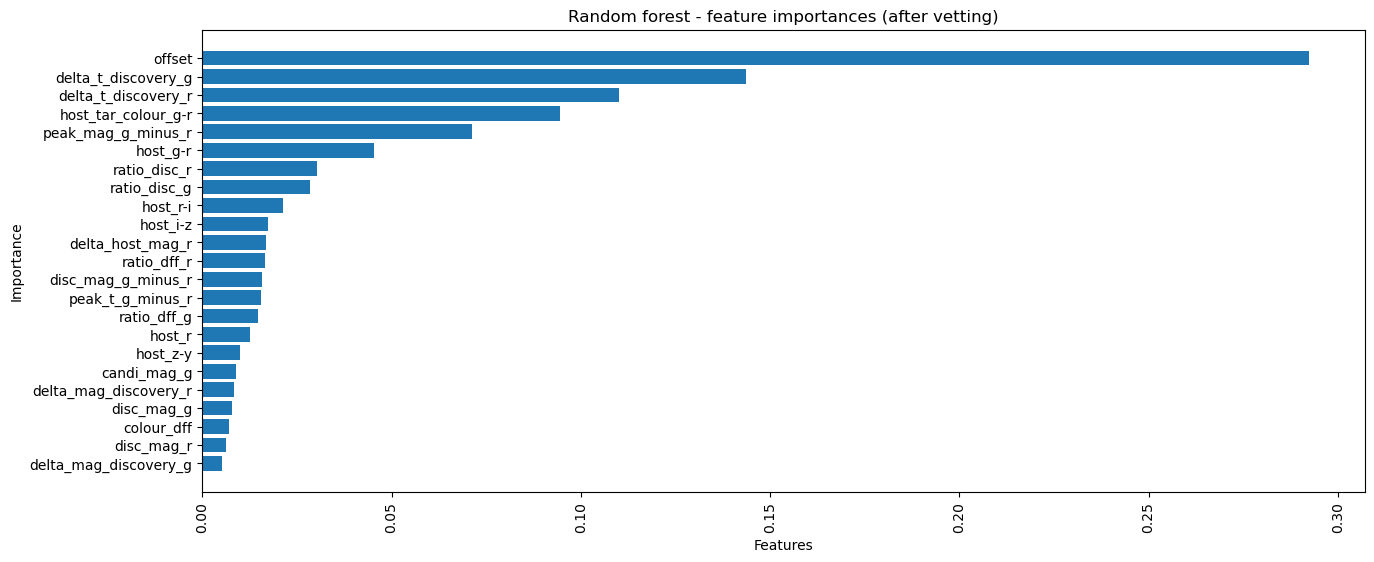

In [101]:
X = np.nan_to_num(df_cm)
y = labels

print(set(labels))
class_weight = {}
for i in np.arange(len(set(labels.flatten()))):
    class_weight[i] = labels.shape[0]/len(np.where(labels.flatten()==i)[0])
# Initialize and train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=4, class_weight = class_weight)
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
feature_names = df_cm.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Visualize feature importances
plt.figure(figsize=(15, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Random forest - feature importances (after vetting)')
plt.xticks(rotation=90)
plt.show()

In [75]:
rf_feature_importance = model.feature_importances_
rf_feature_importance

array([0.02854001, 0.01332475, 0.16287954, 0.07590043, 0.07977724,
       0.01336298, 0.01954255, 0.01607246, 0.138499  , 0.07643488,
       0.03121133, 0.0138353 , 0.15249679, 0.01573981, 0.01543028,
       0.02340587, 0.01357969, 0.02222808, 0.02862999, 0.02071253,
       0.02178214, 0.00979337, 0.00682098])

# Compare with different architectures, for each combination of features
Certainly! Here is a list of machine learning algorithms that use multi-dimensional features for classification:


3. **Support Vector Machines (SVM)**:
   - A powerful classifier that finds the optimal hyperplane to separate different classes in a high-dimensional feature space. Kernel trick can be used to handle non-linear boundaries.
   
4. **Gradient Boosting Machines (GBM)**:
   - An ensemble technique that builds trees sequentially, each new tree correcting errors made by the previous ones. Examples include XGBoost, LightGBM, and CatBoost.

5. **Artificial Neural Networks (ANN)**:
   - Composed of multiple layers of interconnected neurons, ANNs can capture complex patterns in multi-dimensional feature spaces. Deep learning models like Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs) are specialized types of ANNs for specific types of data.

6. **Naive Bayes**:
   - A probabilistic classifier based on Bayes' theorem, assuming independence between features. Variants include Gaussian, Multinomial, and Bernoulli Naive Bayes, depending on the feature distribution.

7. **Linear Discriminant Analysis (LDA)**:
   - A method that finds a linear combination of features that best separates two or more classes. It is particularly useful when dealing with high-dimensional data.

8. **Quadratic Discriminant Analysis (QDA)**:
    - Similar to LDA but allows for non-linear boundaries by assuming different covariance matrices for each class.

10. **AdaBoost**:
    - An ensemble method that combines weak classifiers to form a strong classifier by focusing on errors made by previous classifiers.

11. **Extra Trees (Extremely Randomized Trees)**:
    - An ensemble method similar to random forests but with more randomization in the splitting process, often leading to better generalization.

13. **Gaussian Processes**:
    - A non-parametric method that uses a Bayesian approach to predict distributions over possible classifications based on the features.

14. **Neural Process**

15. **temperal fusion transofrmer**
   

These algorithms are widely used for classification tasks and can handle multi-dimensional feature spaces effectively. The choice of algorithm often depends on the specific characteristics of the data and the problem at hand.

## Now use selected features for training and test with different classifiers.
RF is not better than XGB, so removed here. Focus on XGB and ANN.

In [205]:

    

def feature_reduction(metadata):
    feature_names = ['candi_mag_r', 'disc_mag_r', 'delta_mag_discovery_r', 'delta_t_discovery_band_r', 'delta_t_discovery_r', 'ratio_recent_r', 'ratio_disc_r', 'delta_host_mag_r',
                 'candi_mag_g', 'disc_mag_g', 'delta_mag_discovery_g', 'delta_t_discovery_band_g', 'delta_t_discovery_g', 'ratio_recent_g', 'ratio_disc_g', 'delta_host_mag_g',
                  'peak_mag_g_minus_r', 'peak_t_g_minus_r', 
                  'host_g','host_r','host_i','host_z','host_y', 'host_g-r', 'host_r-i', 
                  'offset']
    df = pd.DataFrame(metadata, columns=feature_names)
    df['host_i-z'] = df['host_i'] - df['host_z']
    df['host_z-y'] = df['host_z'] - df['host_y']
    df['ratio_dff_r']  = df['ratio_disc_r'] - df['ratio_recent_r']
    df['ratio_dff_g']  = df['ratio_disc_g'] - df['ratio_recent_g']
    df['disc_mag_g_minus_r'] = df.apply(lambda row: 0 if row['disc_mag_g'] == 0 or row['disc_mag_r'] == 0 else row['disc_mag_g'] - row['disc_mag_r'], axis=1)
    df['colour_dff'] = df.apply(lambda row: 0 if row['peak_mag_g_minus_r'] == 0 or row['disc_mag_g_minus_r'] == 0 else row['peak_mag_g_minus_r'] - row['disc_mag_g_minus_r'], axis=1)
    df['host_tar_colour_g-r'] = df['delta_host_mag_g'] - df['delta_host_mag_r']
    df = df.drop(['ratio_recent_r', 'ratio_recent_g', 'delta_t_discovery_band_r', 'delta_t_discovery_band_g'], axis = 1)
    return df.to_numpy(), df.columns


### Ramdom Forest

{0, 1, 2}
{0: 1.0204245094112936, 1: 121.33333333333333, 2: 84.93333333333334}
Accuracy: 0.4444444444444444
Confusion Matrix:
[[15  0  0]
 [15  0  0]
 [10  0  5]]
Classification Report:
              precision    recall  f1-score   support

           0       0.38      1.00      0.55        15
           1       0.00      0.00      0.00        15
           2       1.00      0.33      0.50        15

    accuracy                           0.44        45
   macro avg       0.46      0.44      0.35        45
weighted avg       0.46      0.44      0.35        45



/Users/xinyuesheng/anaconda3/envs/astro_py8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xinyuesheng/anaconda3/envs/astro_py8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/xinyuesheng/anaconda3/envs/astro_py8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

<Figure size 1500x600 with 0 Axes>

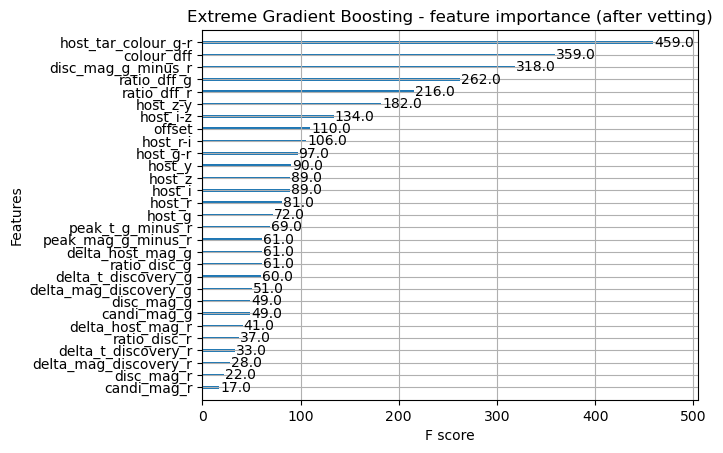

In [206]:

# Split the data
_, X_train, y_train, _, X_test, y_test, feature_importance = preprocessing(filepath, label_dict, hash_path, model_path, 1, None, 'mixed')

# X_train, feature_names = feature_reduction(X_train)
# X_test, feature_names = feature_reduction(X_test)

### Random Forest
class_weight = {}
for i in np.arange(len(set(labels.flatten()))):
    class_weight[i] = labels.shape[0]/len(np.where(labels.flatten()==i)[0])

print(set(labels))
print(class_weight)
# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=4, class_weight = class_weight)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)




In [207]:
set(y_train), set(y_test)

({0, 1, 2}, {0, 1, 2})

In [208]:
from sklearn.model_selection import RandomizedSearchCV

sample_weights = np.array([class_weight[cls] for cls in y_train])

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
rf_model = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=100, cv=5, scoring='balanced_accuracy', verbose=1, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train, sample_weight=sample_weights)
print("Best parameters found: ", random_search.best_params_)
print("Best accuracy: ", random_search.best_score_)

rfop_model= RandomForestClassifier(**random_search.best_params_)
rfop_model.fit(X_train, y_train, sample_weight=sample_weights)
y_pred = rfop_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)




Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

In [319]:
### XGB classifier 
sample_weights = np.array([class_weight[cls] for cls in y_train])

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=10,
    random_state=42
)
xgb_model.fit(X_train, y_train, sample_weight=sample_weights)
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)


KeyError: 2

In [210]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3]
    
}

sample_weights = np.array([class_weight[cls] for cls in y_train])


xgb_model= xgb.XGBClassifier()
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=100, cv=5, scoring='balanced_accuracy', verbose=1, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train, sample_weight=sample_weights)

print("Best parameters found: ", random_search.best_params_)
print("Best accuracy: ", random_search.best_score_)


xgb_model= xgb.XGBClassifier(**random_search.best_params_)
xgb_model.fit(X_train, y_train, sample_weight=sample_weights)
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)




Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'subsample': 0.9, 'n_estimators': 100, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.8}
Best accuracy:  0.8286064189757354
Accuracy: 0.7777777777777778
Confusion Matrix:
[[14  1  0]
 [ 5  8  2]
 [ 1  1 13]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        15
           1       0.80      0.53      0.64        15
           2       0.87      0.87      0.87        15

    accuracy                           0.78        45
   macro avg       0.79      0.78      0.77        45
weighted avg       0.79      0.78      0.77        45



In [212]:
importances = xgb_model.feature_importances_
importances
# feature_names = df_cm.columns
# feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Visualize feature importances
# plt.figure(figsize=(15, 6))
# plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
# plt.xlabel('Features')
# plt.ylabel('Importance')
# plt.title('Random forest - feature importances (after vetting)')
# plt.xticks(rotation=90)
# plt.show()

array([0.01620952, 0.01658195, 0.00759109, 0.05302542, 0.0249984 ,
       0.08101533, 0.0158696 , 0.01663275, 0.0077464 , 0.11075901,
       0.02844163, 0.00847776, 0.02797465, 0.01608388, 0.03154643,
       0.07417631, 0.0660798 , 0.13722236, 0.03448357, 0.02381668,
       0.01506717, 0.05744797, 0.02601906, 0.02852209, 0.01089783,
       0.00644691, 0.01220579, 0.01486837, 0.0297923 ], dtype=float32)

### ANN classifier

In [213]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping  
from tensorflow.keras.layers import Layer



class FeatureWeightedLayer(Layer):
    def __init__(self, feature_weights, **kwargs):
        super(FeatureWeightedLayer, self).__init__(**kwargs)
        self.feature_weights = np.array(feature_weights)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[-1],),
                                      initializer='uniform',
                                      trainable=True)

    def call(self, inputs):
        return inputs * self.feature_weights
    
def ann_classifer(X_train, y_train, X_test, y_test, feature_importance = np.array):

    model = Sequential()
    model.add(FeatureWeightedLayer(feature_importance, input_shape = (None, X_train.shape[-1])))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    earlystop = EarlyStopping(monitor = 'val_loss', patience = 8)

    class_weight = {}
    for i in np.arange(len(set(y_train.flatten()))):
        class_weight[i] = y_train.shape[0]/len(np.where(y_train.flatten()==i)[0])

    model.build()
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate = 5e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy())

    model.fit(X_train, y_train, batch_size = 128, callbacks=[earlystop], class_weight = class_weight, epochs = 300, validation_data = (X_test, y_test), verbose = None)

    return model 
    


In [214]:
ann_model = ann_classifer(X_train, y_train, X_test, y_test, xgb_model.feature_importances_)
y_pred = ann_model.predict(X_test)
y_pred = np.argmax(y_pred, axis = -1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)


2/2 [==============================] - 0s 65ms/step
Accuracy: 0.6888888888888889
Confusion Matrix:
[[12  0  3]
 [ 5  9  1]
 [ 4  1 10]]
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.80      0.67        15
           1       0.90      0.60      0.72        15
           2       0.71      0.67      0.69        15

    accuracy                           0.69        45
   macro avg       0.73      0.69      0.69        45
weighted avg       0.73      0.69      0.69        45



In [328]:
# cm_list = []
# feature_importance = xgb_model.feature_importances_

# for i in np.arange(20):
#     _, X_train, y_train, _, X_test, y_test = preprocessing(filepath, label_dict, hash_path, model_path, 1, None)
#     X_train, _ = feature_reduction(X_train)
#     X_test, _ = feature_reduction(X_test)
#     ann_model = ann_classifer(X_train, y_train, X_test, y_test, feature_importance)
#     y_pred = ann_model.predict(X_test)
#     accuracy = accuracy_score(y_test, np.argmax(y_pred, axis = -1))
#     conf_matrix = confusion_matrix(y_test, np.argmax(y_pred, axis = -1))
#     print(conf_matrix)
#     cm_list.append(conf_matrix)

# cm_list = np.array(cm_list)
# print('Average CM over 20 models: \n', np.mean(cm_list, axis = 0))


Try to remove some features, and see if the accuracy gets better.

In [24]:


def get_xgb_ranking(X_train, y_train, class_weight, feature_names):
    sample_weights = np.array([class_weight[cls] for cls in y_train])
    best_xgb_params = {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.6}
    xgb_model= xgb.XGBClassifier(**best_xgb_params)
    xgb_model.fit(X_train, y_train, sample_weight=sample_weights)

    plt.figure(figsize=(15, 6))
    ax2 = plot_importance(xgb_model)
    ax2.set_yticklabels(feature_names)
    ax2.set_title('Extreme Gradient Boosting - feature importance (after vetting)')
    plt.show()


    return xgb_model.feature_importances_

def get_class_weight(labels):
    class_weight = {}
    for i in np.arange(len(set(labels.flatten()))):
        class_weight[i] = labels.shape[0]/len(np.where(labels.flatten()==i)[0])
    return class_weight

2/2 [==============================] - 0s 31ms/step
[[14  1  0]
 [ 2 13  0]
 [ 1  1 13]]
2/2 [==============================] - 0s 26ms/step
[[13  0  2]
 [ 1 11  3]
 [ 1  1 13]]
2/2 [==============================] - 0s 40ms/step
[[14  0  1]
 [ 3 11  1]
 [ 1  2 12]]


KeyboardInterrupt: 

<Figure size 1500x600 with 0 Axes>

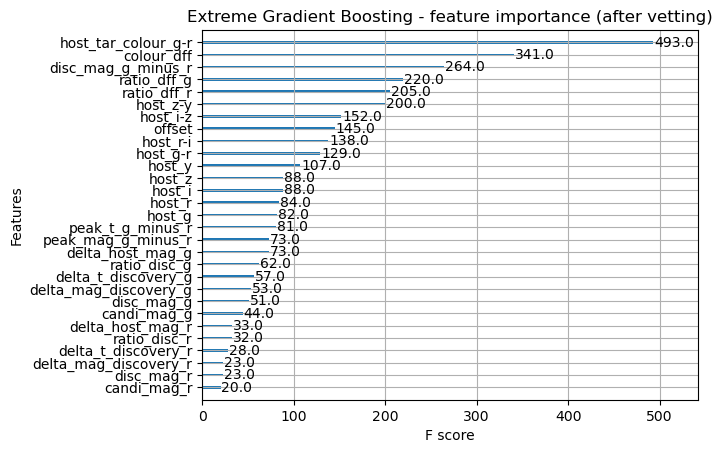

<Figure size 1500x600 with 0 Axes>

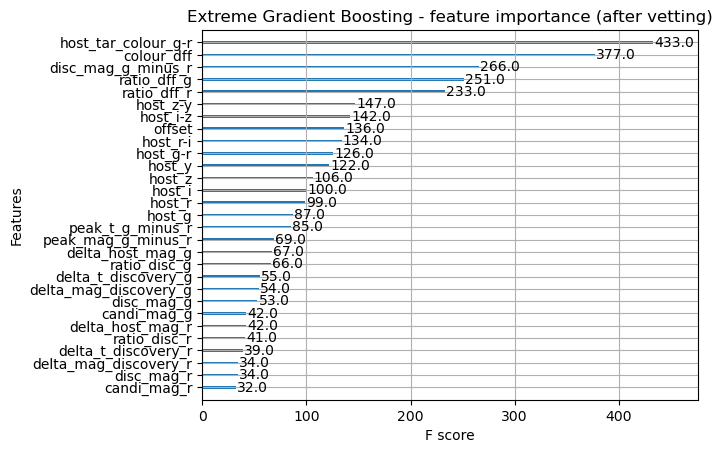

<Figure size 1500x600 with 0 Axes>

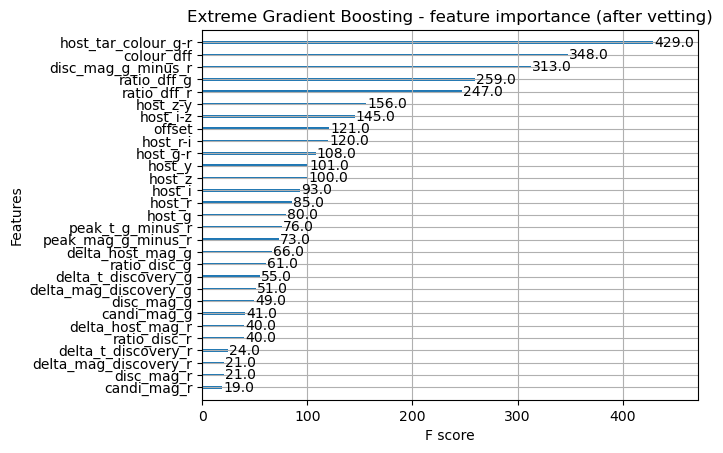

<Figure size 1500x600 with 0 Axes>

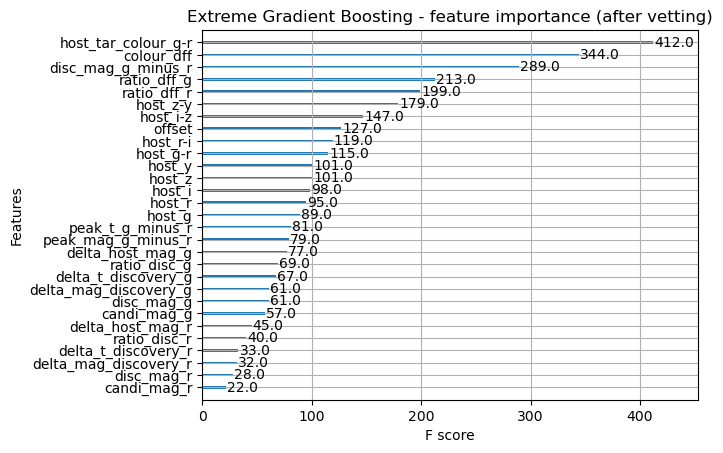

In [26]:
import logging
logging.getLogger('tensorflow').disabled = True
cm_list = []
acc_list = []
for i in np.arange(20):
    _, X_train, y_train, _, X_test, y_test, feature_importance = preprocessing(filepath, label_dict, hash_path, model_path, 1, None, 'mixed')
  
    # X_test, _ = feature_reduction(X_test)

    # class_weight = get_class_weight(y_train)
    # feature_importance = get_xgb_ranking(X_train, y_train, class_weight, feature_names)


    ann_model = ann_classifer(X_train, y_train, X_test, y_test, feature_importance)
    y_pred = ann_model.predict(X_test)
    accuracy = accuracy_score(y_test, np.argmax(y_pred, axis = -1))
    conf_matrix = confusion_matrix(y_test, np.argmax(y_pred, axis = -1))
    print(conf_matrix)
    cm_list.append(conf_matrix)
    acc_list.append(accuracy)

cm_list = np.array(cm_list)
print('Average CM over 20 models: \n', np.mean(cm_list, axis = 0))
print(f'Test set average acc: {np.mean(acc_list)}')

### Ranking combination

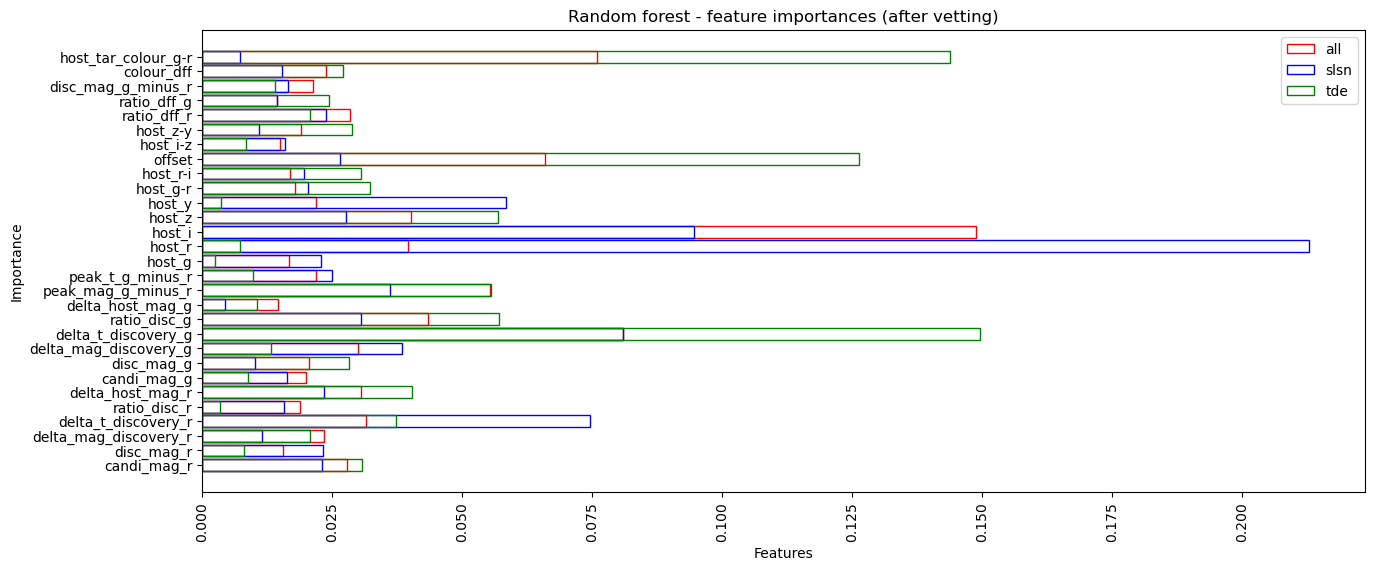

In [325]:
import json 
import pylab as plt 
plt.figure(figsize=(15, 6))
for i, j in zip(['all', 'slsn', 'tde'], ['r', 'b', 'g']):
    file = f'/Users/xinyuesheng/Documents/astro_projects/scripts/classifier_v1/model_with_data/mixed_band/mixed_nor1_add_disc_t_ext_20240628/{i}_xgb_binary_ranking.json'
    f = open(file, 'r')
    data = json.load(f)
    f.close()
    plt.barh(list(data.keys()), list(data.values()), fill = False, label = i, edgecolor = j)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Random forest - feature importances (after vetting)')
    plt.xticks(rotation=90)
plt.legend()
plt.show()


In [326]:
rk_all = {}
for i in ['all', 'slsn', 'tde']:
    file = f'/Users/xinyuesheng/Documents/astro_projects/scripts/classifier_v1/model_with_data/mixed_band/mixed_nor1_add_disc_t_ext_20240628/{i}_xgb_binary_ranking.json'
    f = open(file, 'r')
    data = json.load(f)
    rk_all[i] = data
    f.close()

In [333]:
new_dict = {}
for i in rk_all['all'].keys():
    new_dict[i] = np.sum([rk_all[x][i] for x in rk_all.keys()])
new_dict

{'candi_mag_r': 0.08163346908986568,
 'disc_mag_r': 0.046743253245949745,
 'delta_mag_discovery_r': 0.05574954114854336,
 'delta_t_discovery_r': 0.14357030019164085,
 'ratio_disc_r': 0.03796744532883167,
 'delta_host_mag_r': 0.094212107360363,
 'candi_mag_g': 0.04496301990002394,
 'disc_mag_g': 0.059030892327427864,
 'delta_mag_discovery_g': 0.08166364952921867,
 'delta_t_discovery_g': 0.31153569370508194,
 'ratio_disc_g': 0.13124486990273,
 'delta_host_mag_g': 0.029378993902355433,
 'peak_mag_g_minus_r': 0.14685871824622154,
 'peak_t_g_minus_r': 0.05663312133401632,
 'host_g': 0.042067454662173986,
 'host_r': 0.25999360950663686,
 'host_i': 0.24359369277954102,
 'host_z': 0.12464632838964462,
 'host_y': 0.08383955946192145,
 'host_g-r': 0.07027529738843441,
 'host_r-i': 0.06702976115047932,
 'offset': 0.21854739263653755,
 'host_i-z': 0.039207056164741516,
 'host_z-y': 0.05873867683112621,
 'ratio_dff_r': 0.07308689132332802,
 'ratio_dff_g': 0.053086002357304096,
 'disc_mag_g_minus_r'

In [334]:
for i in new_dict.keys():
    new_dict[i] = new_dict[i]/np.sum(list(new_dict.values()))
new_dict

{'candi_mag_r': 0.027211159218528562,
 'disc_mag_r': 0.015868961256035038,
 'delta_mag_discovery_r': 0.019127005240079216,
 'delta_t_discovery_r': 0.04988404522562153,
 'ratio_disc_r': 0.013635800587370331,
 'delta_host_mag_r': 0.03413404671725485,
 'candi_mag_g': 0.016653065397102866,
 'disc_mag_g': 0.02209509032550391,
 'delta_mag_discovery_g': 0.030994969437255077,
 'delta_t_discovery_g': 0.12056007598915279,
 'ratio_disc_g': 0.054843161481911866,
 'delta_host_mag_g': 0.012681436914487292,
 'peak_mag_g_minus_r': 0.0638517480142785,
 'peak_t_g_minus_r': 0.025545070042585775,
 'host_g': 0.019244910531521924,
 'host_r': 0.12019614889480586,
 'host_i': 0.1203954290812714,
 'host_z': 0.06560050033195894,
 'host_y': 0.045539333647276845,
 'host_g-r': 0.038982580016844286,
 'host_r-i': 0.03783906868550445,
 'offset': 0.12543956224384176,
 'host_i-z': 0.02377417612998965,
 'host_z-y': 0.035954124046559795,
 'ratio_dff_r': 0.04536945495289694,
 'ratio_dff_g': 0.0335306172839465,
 'disc_mag_g

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


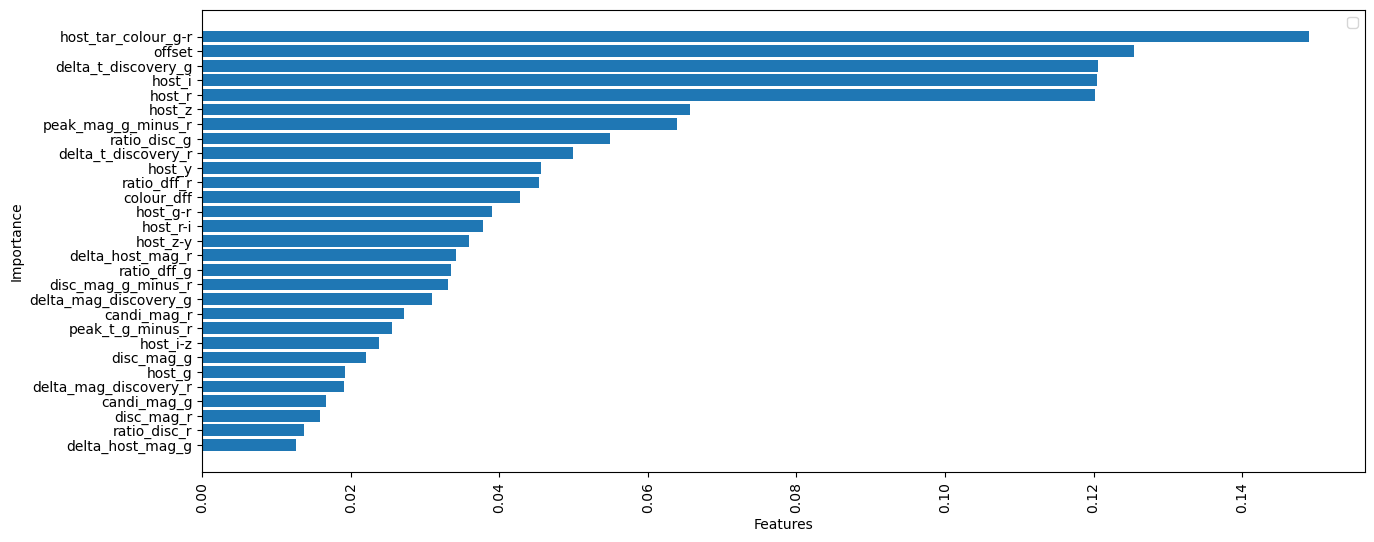

In [335]:
new_dict = dict(sorted(new_dict.items(), key=lambda item: item[1]))
plt.figure(figsize=(15, 6))
plt.barh(list(new_dict.keys()), list(new_dict.values()))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [336]:
with open('/Users/xinyuesheng/Documents/astro_projects/scripts/classifier_v1/model_with_data/mixed_band/mixed_nor1_add_disc_t_ext_20240628/updated_xgb_binary_ranking.json', 'w') as f:
    json.dump(new_dict, f, indent = 4)

### Neual Processes

### Transformer